## Scketch an end to end pipeline to run classification models on new data and give predictions.
1. Get the light curve
    1. get light curve from DR2 set
        1. set parametes 
        1. form url using ZTF API format
        1. query URL
    1. get light curve from Xiao Dian's dataset
        1. set parameters
        1. form URL
        1. query URL
    1. plot light curve per filter
1. Calculate features
    1. Take light curve
    1. calaculate all features
    1. return all features
1. Function run all the models with data
    1. Load all models
    1. pass feature data to all models and get prediction proba
    1. Return prediction proba for each classifier



In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object
import seaborn as sns
import time
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def query_lightcurve_XD(SourceID): 
    """
    Download data for a single source from Xiao Dian's website. Source is identified using SourceID
    """
    url = 'http://variables.cn:88/seldataz.php?SourceID=' + str(SourceID)   
    try:
        lc_complete = pd.read_csv(url, header='infer')
        lc = lc_complete.drop(columns = ['SourceID','flag'])
    except:
        lc_complete = pd.DataFrame()
        lc = pd.DataFrame()
    return lc, lc_complete


In [3]:
def query_lightcurve_DR(RA, Dec): 
    """
    Download data for a single source from DR2 dataset. Source is identified using RA and Dec location
    """
    circle_radius = 0.0028 # 1 arcsec = 0.00028 degress
    t_format = "ipac_table"
    table_format = "FORMAT=" + str(t_format)
    flag_mask = 32768
    mask = "BAD_CATFLAGS_MASK=" + str(flag_mask)
    collect="COLLECTION="+"ztf_dr2"
    numobs = "NOBS_MIN=20"
#     filter_band = "g"
    label = []
    SourceID =[]
    start_time = time.time()
    ra = RA
    dec = Dec
    circle = "POS=CIRCLE"+"+"+str(ra)+"+"+str(dec)+"+"+str(circle_radius)
#     band = "BANDNAME="+ filter_band
    params = circle + "&" +  mask + "&" + numobs + "&" + collect + "&" + table_format

    try:
        url= "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?" + params
        lc_complete = pd.read_csv(url, header=None, delim_whitespace=True, skiprows=55) # extract data
        header = pd.read_csv(url, header=None, sep='|', skiprows=50,usecols=range(1,25), nrows=1)
        lc_complete.columns = header.iloc[0].str.strip()
        lc = lc_complete[['ra','dec','hjd','mag','magerr','filtercode']]
        lc.columns=['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band']
        lc.replace({'zg':'g'},inplace = True)
        lc.replace({'zr':'r'},inplace = True)
#         lc.iloc['HJD',:] = lc.iloc['HJD',:]-2.4e6
    except:
        lc_complete = pd.DataFrame()
        lc = pd.DataFrame()
#     print(url)
    return lc, lc_complete

In [4]:
def plot_lc(lc):
    """
    Function to plot the light curves
    """
    data1 = lc[lc['band']=='r']
    data2 = lc[lc['band']=='g']

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
    ax = axs[0]
    ax.errorbar(data1['HJD'],data1['mag'],yerr = data1['e_mag'],fmt='r.')
    ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
    ax.set_xlabel ('time in HJD')
    ax.set_ylabel('magnitude')
    ax.set_title('Red Filter')

    ax = axs[1]
    ax.errorbar(data2['HJD'],data2['mag'],yerr = data2['e_mag'],fmt='g.')
    ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
    ax.set_xlabel('time in HJD')
    ax.set_ylabel('magnitude')
    ax.set_title('Green filter')

    fig.tight_layout(pad=3.0)
    fig.suptitle('Measured Light Curve', fontsize=16)
    plt.show()

In [5]:
def weighted_mean(mag,mag_err):
    mag2 = (mag_err*mag_err) # mag err square
    mag2_inv = 1/mag2.values; # take inverse of the values
    w = pd.Series(mag2_inv) # covert it back to s series
    sw = w.sum() # sum of weights
    wmag = mag*w # multiply magnitude with weights
    wmean = wmag.sum()/sw # weighted mean
    return wmean

In [6]:
def weighted_mean2(mag,e_mag):
    w = 1/(e_mag*e_mag)
    sw = np.sum(w)
    wmag = w*mag
    wmean = np.sum(wmag)/sw
    return wmean

In [7]:
# welsh J, K statistics
def welsh_staton(mag_series,wmean):
    N = len(mag_series)
    d_i = N/(N-1)*(mag_series - wmean) # replace mean by weighted mean
    d_i1 = d_i.shift(periods=-1)
    d_i1.fillna(0, inplace = True)
    Pi = d_i*d_i1
    Pi_val = Pi.values
    Psign = np.sign(Pi_val)
    Jval = Psign*np.sqrt(np.abs(Pi_val))
    J = np.sum(Jval) 
    K1 = abs(d_i.values)/N
    K2 = np.sqrt(1/N*np.sum(d_i.values*d_i.values))
    K = np.sum(K1*K2)
    return J, K 

In [8]:
def calculate_features(lc):
    """
    Calculate features for a light curve passed as a dataframe.
    """
    g_mean = []
    g_wmean = [] # weighted mean
    g_MAD = []
    g_IQR = []
    g_f60 = []
    g_f70 = []
    g_f80 = []
    g_f90 = []
    g_skew = []
    g_kurtosis = []
    g_welsh_K = []
    g_welsh_J = []

    r_mean = []
    r_wmean = [] # weighted mean
    r_MAD = []
    r_IQR = []
    r_f60 = []
    r_f70 = []
    r_f80 = []
    r_f90 = []
    r_skew = []
    r_kurtosis = []
    r_welsh_K = []
    r_welsh_J = []
    
    if len(lc) >1:
        
        dfg = lc.loc[lc["band"] == "g"]
        dfr = lc.loc[lc["band"] == "r"]
        if len(dfg) > 1:
            N = len(dfg)
            wmean_temp = weighted_mean2(dfg.mag.values,dfg.e_mag.values)
            K_temp, J_temp =  welsh_staton(dfg.mag, wmean_temp )
            g_mean.append(dfg.mag.mean())
            g_wmean.append(wmean_temp) 
            deviation = abs(dfg.mag - dfg.mag.median())
            g_MAD.append(deviation.median())
            g_IQR.append(dfg.mag.quantile(0.75) - dfg.mag.quantile(0.25))
            g_f60.append(dfg.mag.quantile(0.80) - dfg.mag.quantile(0.2))
            g_f70.append(dfg.mag.quantile(0.85) - dfg.mag.quantile(0.15))
            g_f80.append(dfg.mag.quantile(0.9) - dfg.mag.quantile(0.10))
            g_f90.append(dfg.mag.quantile(0.95) - dfg.mag.quantile(0.05))
            g_skew.append(dfg.mag.skew())
            g_kurtosis.append(dfg.mag.kurtosis())
            g_welsh_J.append(J_temp)
            g_welsh_K.append(K_temp)
        else:
            g_mean.append(np.NaN)
            g_wmean.append(np.NaN) 
            g_MAD.append(np.NaN)
            g_IQR.append(np.NaN)
            g_f60.append(np.NaN)
            g_f70.append(np.NaN)
            g_f80.append(np.NaN)
            g_f90.append(np.NaN)
            g_skew.append(np.NaN)
            g_kurtosis.append(np.NaN)
            g_welsh_J.append(np.NaN)
            g_welsh_K.append(np.NaN)
                
        if len(dfr) >1:
            N = len(dfr)
            wmean_temp = weighted_mean2(dfr.mag.values,dfr.e_mag.values)
            K_temp, J_temp =  welsh_staton(dfr.mag, wmean_temp )
            r_mean.append(dfr.mag.mean())
            r_wmean.append(wmean_temp) 
            deviation = abs(dfr.mag - dfr.mag.median())
            r_MAD.append(deviation.median())
            r_IQR.append(dfr.mag.quantile(0.75) - dfr.mag.quantile(0.25))
            r_f60.append(dfr.mag.quantile(0.80) - dfr.mag.quantile(0.2))
            r_f70.append(dfr.mag.quantile(0.85) - dfr.mag.quantile(0.15))
            r_f80.append(dfr.mag.quantile(0.9) - dfr.mag.quantile(0.10))
            r_f90.append(dfr.mag.quantile(0.95) - dfr.mag.quantile(0.05))
            r_skew.append(dfr.mag.skew())
            r_kurtosis.append(dfr.mag.kurtosis())
            r_welsh_J.append(J_temp)
            r_welsh_K.append(K_temp)
        else:
            r_mean.append(np.NaN)
            r_wmean.append(np.NaN) 
            r_MAD.append(np.NaN)
            r_IQR.append(np.NaN)
            r_f60.append(np.NaN)
            r_f70.append(np.NaN)
            r_f80.append(np.NaN)
            r_f90.append(np.NaN)
            r_skew.append(np.NaN)
            r_kurtosis.append(np.NaN)
            r_welsh_J.append(np.NaN)
            r_welsh_K.append(np.NaN)

    else:
        g_mean.append(np.NaN)
        g_wmean.append(np.NaN) 
        g_MAD.append(np.NaN)
        g_IQR.append(np.NaN)
        g_f60.append(np.NaN)
        g_f70.append(np.NaN)
        g_f80.append(np.NaN)
        g_f90.append(np.NaN)
        g_skew.append(np.NaN)
        g_kurtosis.append(np.NaN)
        g_welsh_J.append(np.NaN)
        g_welsh_K.append(np.NaN)
        r_mean.append(np.NaN)
        r_wmean.append(np.NaN) 
        r_MAD.append(np.NaN)
        r_IQR.append(np.NaN) 
        r_f60.append(np.NaN)
        r_f70.append(np.NaN)
        r_f80.append(np.NaN)
        r_f90.append(np.NaN)
        r_skew.append(np.NaN)
        r_kurtosis.append(np.NaN)
        r_welsh_J.append(np.NaN)
        r_welsh_K.append(np.NaN)
        
    # del features
    features = pd.DataFrame()
    N = 1

    # g filter data
    features['g_mean'] = g_mean[0:N]
    features['g_wmean'] = g_wmean[0:N]
    features['g_MAD'] = g_MAD[0:N]
    features['g_IQR'] = g_IQR[0:N]
    features['g_f60'] = g_f60[0:N]
    features['g_f70'] = g_f70[0:N]
    features['g_f80'] = g_f80[0:N]
    features['g_f90'] = g_f90[0:N]
    features['g_skew'] = g_skew[0:N]
    features['g_kurtosis'] = g_kurtosis[0:N]
    features['g_welsh_J'] = g_welsh_J[0:N]
    features['g_welsh_K'] = g_welsh_K[0:N]

    # r filter data
    features['r_mean'] = r_mean[0:N]
    features['r_wmean'] = r_wmean[0:N]
    features['r_MAD'] = r_MAD[0:N]
    features['r_IQR'] = r_IQR[0:N]
    features['r_f60'] = r_f60[0:N]
    features['r_f70'] = r_f70[0:N]
    features['r_f80'] = r_f80[0:N]
    features['r_f90'] = r_f90[0:N]
    features['r_skew'] = r_skew[0:N]
    features['r_kurtosis'] = r_kurtosis[0:N]
    features['r_welsh_J'] = r_welsh_J[0:N]
    features['r_welsh_K'] = r_welsh_K[0:N]

    return features


In [9]:
def prediction_probabilty(features):
    """
    Predict probability for each of the 9 variable types using pre calculated features.
    """
    prob={}
    label = ['BYDra', 'EW', 'SR', 'RSCVN', 'RR', 'DSCT', 'EA', 'Mira', 'RRc']
    prob_pd = pd.DataFrame(columns=['Probability'],index=label)
    if np.isnan(features.iloc[0,:].values).all():
        pass
    else:
        for variable_type in label:
#             print(variable_type)
            name = 'XGBoost'
            filename = '../pickles/'+ name+'_'+variable_type+'.pkl'
            clf = pickle.load(open(filename, 'rb'))
            predict_proba = clf.predict_proba(features)
            prob[variable_type] = round(predict_proba[0,0],2)
    #         prob[variable_type] = clf.predict_proba(features)
        prob_pd['Probability']=prob.values()
    return prob_pd
            

## Run the whole pipeline for 1 light curve

In [10]:
# query data
SourceID = 1
lc1,lc_complete1 =  query_lightcurve_XD(SourceID)
RA = 0.0
Dec = 62.1
lc2,lc_complete2 =  query_lightcurve_DR(RA, Dec)

In [11]:
# calculate features
features = calculate_features(lc2)

In [12]:
features.T.head(24)

,0
g_mean,18.945547
g_wmean,18.094207
g_MAD,0.099257
g_IQR,2.315149
g_f60,2.383024
g_f70,2.436672
g_f80,2.492247
g_f90,2.552729
g_skew,0.394918
g_kurtosis,-1.831794


In [13]:
# run prediction models
prob = prediction_probabilty(features)
prob.head(10)

,Probability
BYDra,0.0
EW,0.0
SR,0.0
RSCVN,0.0
RR,0.0
DSCT,0.0
EA,0.0
Mira,1.0
RRc,0.0


## Batch predictions for precalculated features on many light curves.

In [14]:
df = pd.read_csv('../features/features20000-3.csv', header=None, skiprows=1)
header = pd.read_csv('../features/features20000-3.csv', header=None, nrows=1)
df.columns = header.iloc[0]
df.head()

,sourceid,ID,RAdeg,DEdeg,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,...,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K,Type
0,1.0,ZTFJ000000.13+620605.8,0.000566,62.101631,17.994656,17.992102,0.034,0.07000,0.0820,0.10000,...,0.05125,0.0580,0.06655,0.0797,0.09370,0.105202,-0.632720,0.000801,-0.272584,BYDra
1,2.0,ZTFJ000000.14+721413.7,0.000620,72.237174,19.619402,19.579923,0.111,0.22650,0.2850,0.35950,...,0.22750,0.2712,0.30765,0.3614,0.44115,0.334634,-0.775188,0.017220,-1.523362,EW
2,3.0,ZTFJ000000.19+320847.2,0.000795,32.146449,15.313984,15.313984,0.072,0.14200,0.1580,0.18300,...,0.12600,0.1470,0.16080,0.1760,0.18860,-0.212606,-1.485137,0.004299,0.547045,EW
3,4.0,ZTFJ000000.26+311206.3,0.001085,31.201756,16.353295,16.353295,0.077,0.14900,0.1710,0.18700,...,0.10200,0.1322,0.15980,0.1946,0.20560,0.418285,-1.009552,0.004143,-0.029302,EW
4,6.0,ZTFJ000000.30+233400.5,0.001249,23.566828,17.892283,17.878715,0.102,0.18975,0.2526,0.28225,...,0.22900,0.2700,0.29620,0.3132,0.33620,0.158998,-1.484462,0.013482,-0.366492,EW


In [15]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(level=None, drop=False, inplace=True)
df_features = df.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')

<AxesSubplot:xlabel='Type', ylabel='Count'>

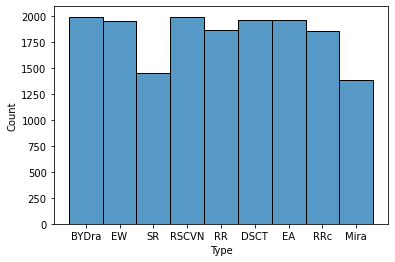

In [16]:
# Plot histogram of variable types in the dataset
import seaborn as sns
sns.histplot(data=df, x=df.Type)

In [44]:
def prediction_probabilty_batch(features):
    """
    Predict probability for each of the 9 variable types using pre calculated features.
    """
    prob={}
    label = ['BYDra', 'EW', 'SR', 'RSCVN', 'RR', 'DSCT', 'EA', 'Mira', 'RRc']
    col_names = ['BYDra', 'EW', 'SR', 'RSCVN', 'RR', 'DSCT', 'EA', 'Mira', 'RRc','Truth']
#     prob_pd = pd.DataFrame(columns=['Probability'],index=label)
    prob_pd = pd.DataFrame(index=features.index,columns=col_names)

    for variable_type in label:
#             print(variable_type)
        name = 'XGBoost'
        filename = '../pickles/'+ name+'_'+variable_type+'.pkl'
        clf = pickle.load(open(filename, 'rb'))
        for i in features.index:
            feat = features.loc[i,:].to_frame()
#             np.reshape(feat,(24,1))
            predict_proba = clf.predict_proba(feat.T)
#             prob[variable_type] = round(predict_proba[0,0],2)
#         prob[variable_type] = clf.predict_proba(features)
            prob_pd[i,variable_type]=round(predict_proba[0,0],2)
#     prob_pd[:,'Truth']=features.Type
    return prob_pd

In [ ]:
prob_pd_batch = prediction_probabilty_batch(df_features)

In [43]:
feat = df_features.loc[0,:].to_frame()
feat.T.head()

,g_mean,g_wmean,g_MAD,g_IQR,g_f60,g_f70,g_f80,g_f90,g_skew,g_kurtosis,...,r_MAD,r_IQR,r_f60,r_f70,r_f80,r_f90,r_skew,r_kurtosis,r_welsh_J,r_welsh_K
0,17.994656,17.992102,0.034,0.07,0.082,0.1,0.126,0.1675,0.323691,0.19051,...,0.025,0.05125,0.058,0.06655,0.0797,0.0937,0.105202,-0.63272,0.000801,-0.272584
